In [30]:
'''
NAME: ADITYA AGRAWAL
ROLL: 2311010
ASSIGN8: BOUNDARY VALUE PROBLEM Solving(Using RK4 and Langrange Interpolation FORMULA) 
DATE-29/10/2025
'''


'\nNAME: ADITYA AGRAWAL\nROLL: 2311010\nASSIGN8: BOUNDARY VALUE PROBLEM Solving(Using RK4 and Langrange Interpolation FORMULA) \nDATE-29/10/2025\n'

In [31]:
import sys
import matplotlib.pyplot as plt
sys.path.append('c:/Users/mayur/ClonedGitRepo/COMPUTATIONAL_PHYSICS/LABWORK')
import adilib_class as ad
import math


T(L) = 200.000000 °C (iters=1)
x where T=100°C: 4.425211027225716


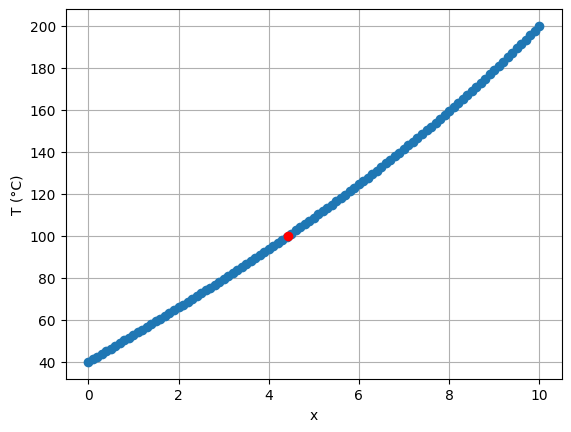

In [ ]:
# Question 1 — shooting + RK4 using library solver wrapper
import importlib
importlib.reload(ad)  # reload library in case it was edited

alpha = 0.01  # heat-loss coefficient
Ta = 20       # ambient temperature
L = 10        # rod length
T0 = 40       # boundary at x=0
TL = 200      # boundary at x=L

# ODE system: y = [T, dT/dx]
# returns [dT/dx, d2T/dx2]
def heat_sys(t, y):
    return [y[1], -alpha*(Ta - y[0])]

# Run the RK4 system solver for a given initial slope zeta
# returns T(L), full t (x) and y arrays
def shoot(zeta, dx):
    t_vals, y_vals = ad.rk4_system_solver(heat_sys, [T0, zeta], 0, L, dx)
    return y_vals[-1][0], t_vals, y_vals

# Find the correct initial slope (zeta) so that T(L) ~= TL
# Uses a simple secant-like linear interpolation between two guesses
def find_zeta(dx, zl, zh, tol=1e-2, maxit=50):
    Tl, _, _ = shoot(zl, dx)
    Th, _, _ = shoot(zh, dx)
    if (Tl - TL)*(Th - TL) > 0:
        raise ValueError('initial guesses must bracket target')
    for it in range(1, maxit+1):
        # linear interpolation on final-temperature vs initial-slope
        zn = zl + (zh - zl)*(TL - Tl)/(Th - Tl)
        Tn, t_vals, y_vals = shoot(zn, dx)
        if abs(Tn - TL) < tol:
            xs = t_vals
            return xs, y_vals, Tn, it
        # update the bracket
        if (Tl - TL)*(Tn - TL) < 0:
            zh, Th = zn, Tn
        else:
            zl, Tl = zn, Tn
    xs = t_vals
    return xs, y_vals, Tn, it

# Find x where T crosses a target value using linear interpolation on the grid
def find_x_for_T(xs, ys, T_target):
    for i in range(len(xs)-1):
        a = ys[i][0]; b = ys[i+1][0]
        if (a - T_target)*(b - T_target) <= 0:
            return xs[i] if b==a else xs[i] + (T_target - a)*(xs[i+1]-xs[i])/(b-a)
    return None

# run (library RK4 wrapper)
import matplotlib.pyplot as plt

dx = 0.1
# find initial slope and solution
xs, ys, Tf, iters = find_zeta(dx, 0.0, 20.0)
print(f'T(L) = {Tf:.6f} °C (iters={iters})')
# locate where T = 100°C
x100 = find_x_for_T(xs, ys, 100.0)
print('x where T=100°C:', x100)

# quick plot: temperature vs x with marker at T=100°C (if found)
plt.plot(xs, [r[0] for r in ys], '-o')
if x100 is not None:
    plt.plot(x100, 100, 'ro')
plt.xlabel('x'); plt.ylabel('T (°C)'); plt.grid(True); plt.show()


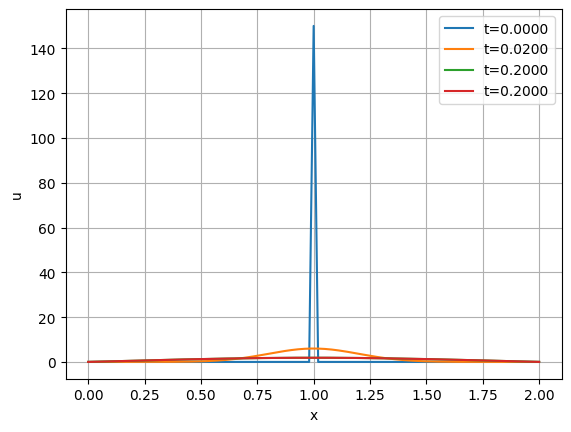

final time ≈ 0.200000 s, max u= 1.8668244434314518


In [ ]:
# Question 2 — FTCS (compact helpers)
import matplotlib.pyplot as plt

# build grid and initial condition: center spike
def init_ftcs(L=2.0, dx=0.01, spike=300.0):
    nx = int(L / dx) + 1
    x = [i*dx for i in range(nx)]
    u = [0.0]*nx
    u[nx//2] = spike
    return x, u

# explicit FTCS time-stepper
# returns final solution and a few snapshots for plotting
def ftcs(u0, dx, dt, t_final):
    n = max(1, int(t_final/dt))
    u = u0.copy()
    snaps = []
    for k in range(n):
        # explicit update (interior points only)
        u_new = u.copy()
        for i in range(1, len(u)-1):
            u_new[i] = u[i] + (dt/dx**2)*(u[i+1] - 2*u[i] + u[i-1])
        u = u_new
        # record a few times for plotting (start, early, final)
        if k in {0, int(n*0.1), n-1}:
            snaps.append(((k+1)*dt, u.copy()))
    snaps.append((n*dt, u.copy()))
    return u, snaps

# run
L = 2.0; dx = 0.01
x, u0 = init_ftcs(L, dx)
# choose dt small enough for stability: dt/dx^2 <= 0.5
dt = 0.25*dx**2; t_final = 0.2
uf, snaps = ftcs(u0, dx, dt, t_final)

# plot snapshots (labelled by time)
plt.figure()
for t, u in snaps:
    plt.plot(x, u, label=f't={t:.4f}')
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.grid(True); plt.show()
print('final time ≈', f'{(int(t_final/dt))*dt:.6f}', 's, max u=', max(uf))
